## A Graph Diffusion Model in Pytorch

Author: Amiri Hayes

In this notebook I want to build a very simple Graph Diffusion Model.

**Sources:**
- ChatGPT
- https://arxiv.org/pdf/2209.14734
- https://github.com/tanelp/tiny-diffusion
- https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=HhIgGq3za0yh


In [137]:
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

Step 1: Create & Visualize Training Data

In [138]:
def generate_data(num_graphs, n=20, p=0.3):
    graphs, adj_matrices = [], []

    for _ in range(num_graphs):
        # Generate a random graph from a distribution
        G = nx.erdos_renyi_graph(n=n, p=p)
        graphs.append(G)
        
        # Extract adjacency matrix
        adj_matrix = nx.adjacency_matrix(G).todense()
        adj_matrices.append(torch.tensor(adj_matrix, dtype=torch.float32))
    
    return graphs, adj_matrices

# Generate training data
num_graphs = 16 # n = 1024 for final model
graphs, adj_matrices = generate_data(num_graphs)

In [139]:
def edge_diffusion_process(adj_matrix, steps=10, add_prob=0.05, remove_prob=0.05):
    """
    Args:
    - adj_matrix (torch.Tensor): Adjacency matrix of shape (n_nodes, n_nodes).
    - steps (int): Number of diffusion steps to perform.
    - add_prob (float): Probability of adding an edge.
    - remove_prob (float): Probability of removing an edge.
    """
    n_nodes = adj_matrix.size(0)
    
    for _ in range(steps):
        for i in range(n_nodes):
            for j in range(i+1, n_nodes):  # Only iterate over upper triangle
                
                # for denoising, use cosine_similarity(node_feature[i], node_feature[j]) > ... instead of np.random.rand() < ...
                if adj_matrix[i, j] == 1 and np.random.rand() < remove_prob:
                    adj_matrix[i, j] = adj_matrix[j, i] = 0

                elif adj_matrix[i, j] == 0 and np.random.rand() < add_prob:
                    adj_matrix[i, j] = adj_matrix[j, i] = 1
                    
    return adj_matrix

In [140]:
# Perform edge diffusion process (UPDATED)
diff_t1_adj_matrices = []
diff_t2_adj_matrices = []

for i in range(num_graphs):
    adj = adj_matrices[i].clone()
    t = np.random.randint(0, 5)

    diff_t1_adj_matrix = edge_diffusion_process(adj, steps=t, add_prob=0.05, remove_prob=0.05)
    diff_t2_adj_matrix = edge_diffusion_process(adj, steps=t+1, add_prob=0.05, remove_prob=0.05)

    diff_t1_adj_matrices.append(torch.tensor(diff_t1_adj_matrix, dtype=torch.float32))
    diff_t2_adj_matrices.append(torch.tensor(diff_t2_adj_matrix, dtype=torch.float32))

/var/tmp/ipykernel_4137900/2924102603.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff_t1_adj_matrices.append(torch.tensor(diff_t1_adj_matrix, dtype=torch.float32))
/var/tmp/ipykernel_4137900/2924102603.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff_t2_adj_matrices.append(torch.tensor(diff_t2_adj_matrix, dtype=torch.float32))


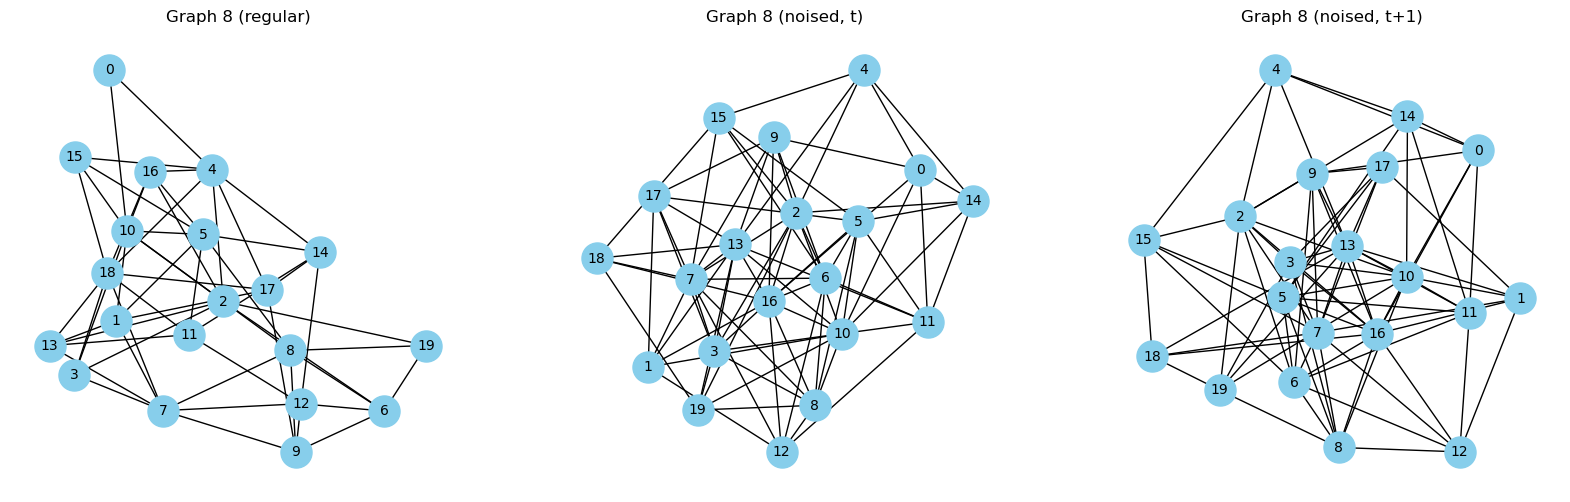

In [141]:
n = 8 # index of graph you'll visualize
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot the nth graph in the dataset (normal)
nx.draw(graphs[n], ax=ax1, with_labels=True, node_color='skyblue', node_size=500, font_size=10)
ax1.set_title("Graph " + str(n) + " (regular)")

# Plot the nth graph in the dataset (noised, t)
G_diffused_1 = nx.from_numpy_array(diff_t1_adj_matrices[n].numpy())
nx.draw(G_diffused_1, ax=ax2, with_labels=True, node_color='skyblue', node_size=500, font_size=10)
ax2.set_title("Graph " + str(n) + " (noised, t)")

# Plot the nth graph in the dataset (noised, t+1)
G_diffused_2 = nx.from_numpy_array(diff_t2_adj_matrices[n].numpy())
nx.draw(G_diffused_2, ax=ax3, with_labels=True, node_color='skyblue', node_size=500, font_size=10)
ax3.set_title("Graph " + str(n) + " (noised, t+1)")

# Display the plots
plt.show()

In [142]:
from torch.utils.data import DataLoader, TensorDataset

# Flatten Adjacency Matrices
for idx, _ in enumerate(adj_matrices):
    diff_t1_adj_matrices[idx] = diff_t1_adj_matrices[idx].view(1, -1)
    diff_t2_adj_matrices[idx] = diff_t2_adj_matrices[idx].view(1, -1)

# Convert lists to PyTorch tensors
diff_t1_adj_matrices = torch.cat(diff_t1_adj_matrices, dim=0)  # Shape: [num_graphs, 1, num_nodes * num_nodes]
diff_t2_adj_matrices = torch.cat(diff_t2_adj_matrices, dim=0)  # Shape: [num_graphs, 1, num_nodes * num_nodes]

# Create PyTorch Dataset
dataset = TensorDataset(diff_t1_adj_matrices, diff_t2_adj_matrices)
data_loader = DataLoader(dataset, batch_size = 32, shuffle=True)

Step 2: Diffusion Model (Denoiser)

In [143]:
class GraphCleanerMLP(nn.Module):
    def __init__(self, input_size=400, hidden_size=256, output_size=400):
        super(GraphCleanerMLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x) 
        return x

# float adjacency matrix -> graph with edge features -> graph neural network -> output node features -> denoising

In [144]:
model = GraphCleanerMLP()
# criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [145]:
num_epochs = 100
for epoch in range(num_epochs):
    for noisy_adj, noisier_adj in data_loader:
        
        # Forward pass
        outputs = model(noisy_adj)
        
        # Compute the target indices for CrossEntropyLoss
        # target_indices = torch.argmax(noisier_adj, dim=1)
        
        # Compute the loss
        loss = criterion(outputs, noisier_adj)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 5 == 4:    
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete!")

Epoch [5/100], Loss: 0.6845
Epoch [10/100], Loss: 0.6424
Epoch [15/100], Loss: 0.6163
Epoch [20/100], Loss: 0.6084
Epoch [25/100], Loss: 0.6038
Epoch [30/100], Loss: 0.5994
Epoch [35/100], Loss: 0.5947
Epoch [40/100], Loss: 0.5848
Epoch [45/100], Loss: 0.5565
Epoch [50/100], Loss: 0.5160
Epoch [55/100], Loss: 0.4688
Epoch [60/100], Loss: 0.4142
Epoch [65/100], Loss: 0.3503
Epoch [70/100], Loss: 0.2914
Epoch [75/100], Loss: 0.2448
Epoch [80/100], Loss: 0.1955
Epoch [85/100], Loss: 0.1343
Epoch [90/100], Loss: 0.0709
Epoch [95/100], Loss: 0.0244
Epoch [100/100], Loss: 0.0054
Training complete!


Step 3: Model Sampling

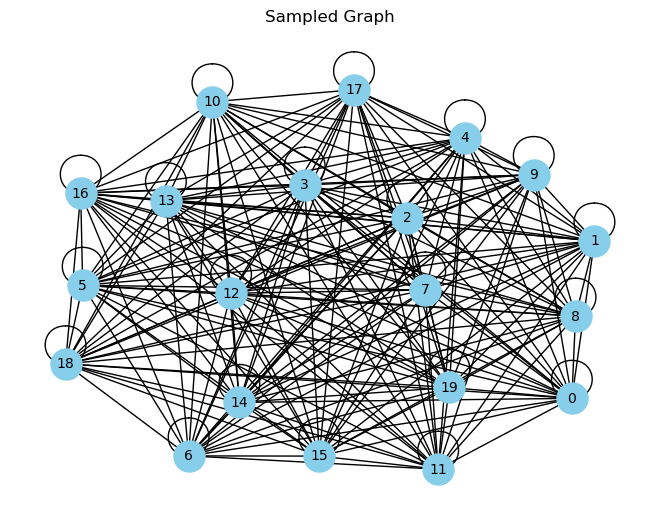

[[149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
  149 149]
 [149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
  149 149]
 [149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
  149 149]
 [149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
  149 149]
 [149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
  149 149]
 [149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
  149 149]
 [149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
  149 149]
 [149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
  149 149]
 [149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
  149 149]
 [149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
  149 149]
 [149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
  149 149]
 [149 149 149 149 149 149 149 149  53 149 149 149 149 149 149 149

In [150]:
model.eval()  # Set model to evaluation mode

# Example function to sample from the model
def sample_from_model(model, idx):
    with torch.no_grad():
        # Generate a random input (you can use any initial noisy adjacency matrix here)
        noisy_adj = diff_t1_adj_matrices[idx]  # Example noisy input
        
        # Forward pass through the model
        outputs = model(noisy_adj)
        
        # Convert outputs to probabilities using softmax
        probabilities = torch.softmax(outputs, dim=-1)
        
        # Sample from the output probabilities
        sampled_indices = torch.multinomial(probabilities, 400, replacement=True)
        
        # Reshape sampled indices into a 20x20 adjacency matrix
        sampled_adj = sampled_indices.view(20, 20)
        
        return sampled_adj.numpy()

# Example of sampling
sampled_matrix = sample_from_model(model, 4)
G_diffused = nx.from_numpy_array(sampled_matrix)
nx.draw(G_diffused, with_labels=True, node_color='skyblue', node_size=500, font_size=10)
plt.title("Sampled Graph")
plt.show()
print(sampled_matrix)